In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import mean_firing_rate
from elephant.statistics import time_histogram, instantaneous_rate
from elephant.kernels import GaussianKernel

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def brain_area(neuron):
    if neuron in ['189139306', '1891406', '1891407', '189141804', '1891421','189142510', '1891436',
                    '189144701', '189144904', '189147105', '189150602', '189151102', '189152601',
                    '189154404', '189154602', '189155501', '189156205', '189157901', '189158601',
                    '1891598', '189160302', '189160702', '189161203', '189161604', '1891626', '189163101',
                    '189163701', '189164103', '189164404', '189164801', '189164803', '189165003',
                    '1891653', '1892063', '189207101', '189207302', '189207501', '189208001',
                    
                    '1364705', '1365201', '1365301', '1365501', '13656021', '1365701', '1365802', 
                    '1365902', '1366002', '1366101', '1366303',  '1366403', '1366605', '13667021',
                    '1366804', '1366904', '1367003', '1367104', '1372803', '1373003', '1373103' ]:
        
        return 'LIP'
    
    elif neuron in ['189168701', '189169502', '189171003', '189171602', '189172801', '189173101',
                      '189173801', '189174201','189175201', '189175801', '189176101', '189176501',
                      '189176901', '189177402', '189177701', '1891783', '189179001', '189179002',
                      '1891793', '189179702', '189180001', '189181001', '189181502', '1891819',
                      '189182202', '189182501', '189182901', '189183201', '189183402', '1891841',
                      '189184601', '1891857', '189186201', '189187301', '189188901', '189189601',
                      '189191601', '189191602', '1891918', '189192001', '189192201', '189192401',
                      '1891935', '189194301', '189195301', '189196301', '189196401', '189209101',
                      '189209503', '189210001', '189210901', 
                      
                      '1367203', '1367701', '1367802',  '1367903', '1368502', '1368802', '1369304',
                      '1369403', '1369702', '1369901', '1370002', '1370202', '1370304', '1370603',
                      '1371103', '1371202',  '1371303', '1371503', '1371803', '1371901', '1372003',
                      '1372103', '1372301', '1372402', '1372603', '1372703']:
        
        return 'DLPFC'
    
    
    else:
        
        return 'Other'

    
###

def pos_xy_to_angle(x, y):
    deg = np.degrees(np.arctan2(y,x))
    if deg<0:
        deg=360-abs(deg)
    
    deg=int(deg)
    return deg


def RFangle_2_octaves(angle):
    ## round RF to octave
    value = min([0, 45, 90, 135, 180, 225, 270, 315, 360], key=lambda x:abs(x-angle))
    
    if value==360:
        value=0
    
    return value

In [9]:
trials_=[]

for monkey_directory in ['Speriatus', 'Mojo']:
    path = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\' +monkey_directory
    ### path = 'C:\\Users\\David\\Desktop\\fast_process_gottlieb\\' +monkey_directory
    Monkey = path.split('\\')[-1]
    for file_to_use in os.listdir(path):  #
        neuron = file_to_use.split('.')[0]
        print(Monkey, neuron)
        #########
        ### Open file
        f = scipy.io.loadmat(os.path.join(path, file_to_use))
        ########
        ### Check if there is spiking data inside
        if np.shape(f['data']['spikes'][0][0][0]) ==(0,): 
            print('No data')
            
        else:
            ########
            ### Receptive field location in degrees
            ### Spikes 
            df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
            df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            ########
            ### Events
            Dict_events={}
            for i in range(0, len(f['data']['events'][0][0][0])     ):
                events = pd.DataFrame( f['data']['events'][0][0][0][i])
                events.columns=['time', 'code']
                Dict_events[str(i)]= events
            #
            ########
            ### Descriptors & Bad trials
            ## Use the Descriptors to make the booleans to select the HIT trials
            lists=[]
            for T in range(0, len(f['data']['descriptors'][0][0][0])):
                lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )
            #
            Descriptors = pd.DataFrame(lists)
            Descriptors=Descriptors.transpose()
            Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]
            # 6 "failed" // performance code, as defined below 
            boolean_hit_trials = Descriptors.iloc[6].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,0,15,99,100]) #Descriptors.iloc[6,:]==1
            ########
            ### Bad trials
            ## take off the bad trials
            bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
            bad = bad.transpose()
            bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            #each column in a trial; if 1, discard it
            boolean_bad_trials = bad.iloc[0,:]!=1
            ########
            ########
            ### Boolean combinging success trials and correct
            boolean_keep = boolean_hit_trials & boolean_bad_trials 
            #print('Trials keept = ' +str(sum(boolean_keep)))
            #print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))
            ########
            ### df_spikes_correct
            indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
            df_spikes = df_spike_time[list(indexes_trials_keep)]
            df_spikes = df_spikes.iloc[4:, :] #remove the first 4 rows, no spikes
            df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() #remove columns full of nans
            ########
            ########
            ########
            ### Get the firing rate of each trial (Gaussian fit and auto)
            ### turorial https://elephant.readthedocs.io/en/latest/tutorials/statistics.html
            Descriptors_use = Descriptors[list(df_spikes.columns)]    
            for TRIAL in list(df_spikes.columns):
                ###### firing rates
                trials_.append( [Descriptors_use[TRIAL].iloc[20],
                                 Descriptors_use[TRIAL].iloc[24],
                                 Descriptors_use[TRIAL].iloc[1],
                                 Descriptors_use[TRIAL].iloc[19],
                                 Descriptors_use[TRIAL].iloc[9],
                                 Descriptors_use[TRIAL].iloc[6],
                                 Descriptors_use[TRIAL].iloc[18],
                                 Descriptors_use[TRIAL].iloc[10],
                                 Descriptors_use[TRIAL].iloc[21],
                                 Monkey,
                                 neuron,
                                 brain_area(neuron),
                                 (Descriptors_use[TRIAL].iloc[18]==Descriptors_use[TRIAL].iloc[1])*1,
                                 TRIAL])
                

                               
                               
                               
#####

df_performance=pd.DataFrame(trials_)
df_performance.columns=['TDOA', 'TDconf', 'targetloc', 'distLoc', 'fixationtime',
                       'perfromance_code', 'saccadeChoice', 'cueDuration',  'distDur',
                       'monkey', 'neuron', 'brain_region', 'performance', 'trial' ]
                        



Speriatus 189139306
Speriatus 1891406
Speriatus 1891407
Speriatus 189141804
Speriatus 1891421
Speriatus 1891436
Speriatus 189144701
Speriatus 189144904
Speriatus 189147105
Speriatus 189150602
Speriatus 189151102
Speriatus 189152601
Speriatus 189154404
Speriatus 189154602
Speriatus 189155501
Speriatus 189156205
Speriatus 189157901
Speriatus 189158601
Speriatus 1891598
Speriatus 189160302
Speriatus 189160702
Speriatus 189161604
Speriatus 1891626
Speriatus 189163101
Speriatus 189163701
Speriatus 189164103
Speriatus 189164404
Speriatus 189164801
Speriatus 189164803
Speriatus 189165003
Speriatus 1891653
Speriatus 189168701
Speriatus 189169502
Speriatus 189171003
Speriatus 189171602
Speriatus 189172801
Speriatus 189173101
Speriatus 189173801
Speriatus 189174201
Speriatus 189175201
Speriatus 189175801
Speriatus 189176101
Speriatus 189176501
Speriatus 189176901
Speriatus 189177402
Speriatus 189177701
Speriatus 1891783
Speriatus 189179001
Speriatus 189179002
Speriatus 1891793
Speriatus 18917970

In [10]:
df_performance

,TDOA,TDconf,targetloc,distLoc,fixationtime,perfromance_code,saccadeChoice,cueDuration,distDur,monkey,neuron,brain_region,performance,trial
0,0,1,0,7,800,15,4,100,100,Speriatus,189139306,LIP,0,0
1,100,2,0,3,800,3,4,100,100,Speriatus,189139306,LIP,0,1
2,100,2,0,3,500,1,0,100,100,Speriatus,189139306,LIP,1,2
3,0,0,0,99,800,1,0,100,100,Speriatus,189139306,LIP,1,3
4,100,1,0,1,500,1,0,100,100,Speriatus,189139306,LIP,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60761,0,3,1,0,800,13,0,100,100,Mojo,1372402,DLPFC,0,391
60762,0,3,1,0,800,13,0,100,100,Mojo,1372402,DLPFC,0,392
60763,0,3,1,0,800,1,1,100,100,Mojo,1372402,DLPFC,1,393
60764,100,6,6,3,300,3,1,100,100,Mojo,1372402,DLPFC,0,394


In [18]:
df1=df_performance.loc[df_performance['perfromance_code'].isin([1, 15, 8])]

performance=[]
for performance_ in ['correct', 'wrong']:
    if performance_=='correct':
        perf_=1
    else:
        perf_=0
    #
    for monkey in ['Speriatus', 'Mojo']:
        for TDOA in [0,100,200,800]:
            for dist in ['near', 'far']:
                if dist=='near':
                    configs = [1,3] ##,5,7]
                elif dist=='far':
                    configs=[2,4] ##,6]
                    #
                ##
                number=[] ##for each neuron in the monkey the ones that fullfill the condition
                for neuron in df1.loc[ df1['monkey']==monkey].neuron.unique():
                    number_trials = len( df1.loc[ (df1['performance']==perf_) & (df1['monkey']==monkey) &
                                         (df1['neuron']==neuron) &
                                         (df1['TDOA']==TDOA)  & (df1['TDconf'].isin(configs))].trial.unique())
                    #
                    number.append(number_trials)
                
                ###
                performance.append([sum(number), performance_, monkey, TDOA, dist])

#        
performance=pd.DataFrame(performance)
performance.columns=['n_trials', 'performance', 'monkey', 'TDOA', 'distance']
performance.head()

,n_trials,performance,monkey,TDOA,distance
0,4375,correct,Speriatus,0,near
1,3146,correct,Speriatus,0,far
2,2939,correct,Speriatus,100,near
3,3302,correct,Speriatus,100,far
4,3221,correct,Speriatus,200,near


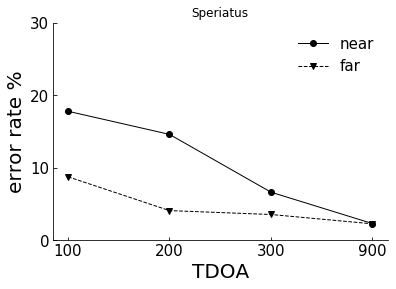

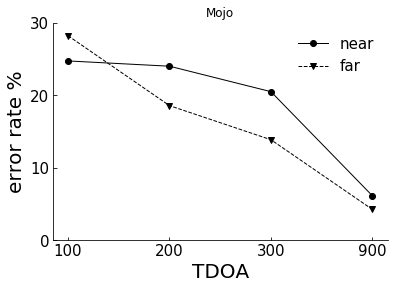

In [15]:
#### [ 1, 15]

for Monkey in ['Speriatus', 'Mojo']:
    ##
    c_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_n = list(w_n/(w_n+c_n)*100)


    c_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_f = list(w_f/(w_f+c_f)*100)


    ###
    plt.figure()
    plt.plot([0,1,2,3], percentages_n, linestyle='-', color='k', marker='o', linewidth=1, label='near' )
    plt.plot([0,1,2,3], percentages_f, linestyle='--', color='k', marker='v', linewidth=1, label='far' )
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.ylabel('error rate %', fontsize=20)
    plt.xlabel('TDOA', fontsize=20)
    plt.xticks([0,1,2,3], [100,200,300,900])
    plt.yticks([0,10,20,30])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(Monkey)
    plt.legend( loc=1, frameon=False, prop={'size': 15})
    plt.show()

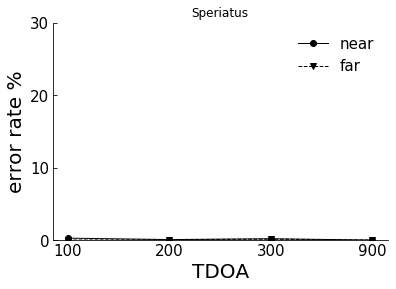

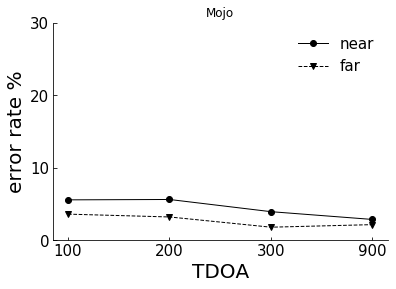

In [17]:
#### [ 1, 8]
for Monkey in ['Speriatus', 'Mojo']:
    ##
    c_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_n = list(w_n/(w_n+c_n)*100)


    c_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_f = list(w_f/(w_f+c_f)*100)


    ###
    plt.figure()
    plt.plot([0,1,2,3], percentages_n, linestyle='-', color='k', marker='o', linewidth=1, label='near' )
    plt.plot([0,1,2,3], percentages_f, linestyle='--', color='k', marker='v', linewidth=1, label='far' )
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.ylabel('error rate %', fontsize=20)
    plt.xlabel('TDOA', fontsize=20)
    plt.xticks([0,1,2,3], [100,200,300,900])
    plt.yticks([0,10,20,30])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(Monkey)
    plt.legend( loc=1, frameon=False, prop={'size': 15})
    plt.show()

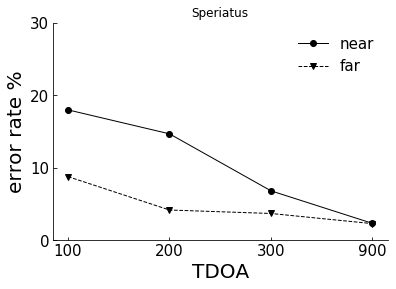

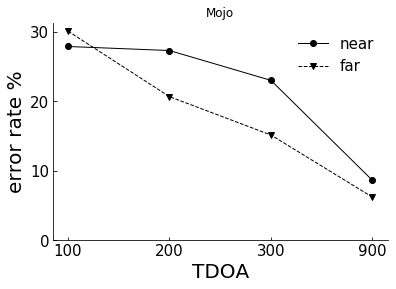

In [19]:
#### [ 1, 15, 8]

for Monkey in ['Speriatus', 'Mojo']:
    ##
    c_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_n = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='near') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_n = list(w_n/(w_n+c_n)*100)


    c_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='correct') ].n_trials.values

    w_f = performance.loc[(performance['monkey']==Monkey) & 
                       (performance['distance']=='far') & 
                       (performance['performance']=='wrong') ].n_trials.values

    percentages_f = list(w_f/(w_f+c_f)*100)


    ###
    plt.figure()
    plt.plot([0,1,2,3], percentages_n, linestyle='-', color='k', marker='o', linewidth=1, label='near' )
    plt.plot([0,1,2,3], percentages_f, linestyle='--', color='k', marker='v', linewidth=1, label='far' )
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.ylabel('error rate %', fontsize=20)
    plt.xlabel('TDOA', fontsize=20)
    plt.xticks([0,1,2,3], [100,200,300,900])
    plt.yticks([0,10,20,30])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(Monkey)
    plt.legend( loc=1, frameon=False, prop={'size': 15})
    plt.show()